In [1]:
## Code modified from TDT's Python Package examples
## https://www.tdt.com/support/python-sdk/offline-analysis-examples/licking-bout-epoc-filtering/

In [1]:
import numpy as np
import scipy
from scipy import stats, signal, ndimage
from scipy.signal import detrend, resample, medfilt, butter, lfilter, filtfilt
import matplotlib.pyplot as plt
from statsmodels import robust
import tdt

In [2]:
## FUNCTIONSSSSS ##

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def load_dlc(csv_file_path):
    import numpy
    M = np.loadtxt(csv_file_path, delimiter=',', skiprows=3)
    # create nose & TTI vectors
    Nx = M[:, 1]
    Ny = M[:, 2]
    Tx = M[:, 10]
    Ty = M[:, 11]
    # calculate centroids using euclidean distance b/w them
    Cx = (Nx + Tx)/2
    Cy = (Ny + Ty)/2
    return Cx, Cy

def load_fp(fp_file_path):
    import tdt
    data = tdt.read_block(fp_file_path, evtype=['streams', 'epocs'])
    GCAMP = data.streams['GCP1'].data[2,:]
    ISOS = data.streams['GCP2'].data[2,:]
    fs = data.streams['GCP1'].fs
    fram = data.epocs['Fram'].onset
    return GCAMP, ISOS, fram, fs  

def downsample_FP(signal, fram, fs, Cx, offset=1, cam_fr=40):
    """
    Inputs:
    -------
    signal: GCAMP (or isosbestic) array of signal values from the TDT system
    fram: array of camera onset times accoording to TDT
    fs: sampling frequency of data
    cam_fr: camera frame rate. in our case values are the same for all cage day trials, but they may not always be!
    Cx: required for downsampling based on positional tracking using dlc
    
    Returns:
    --------
    signal_ds: downsampled signal based on dx
    """
    import math
    cam_fr = 40
    sr_diff = fs/cam_fr
    rec_onset = fram[0]
    rec_offset = fram[-1]
    
    # Turn the GCAMP frames into seconds 
    signal_times = np.arange(0, (len(signal)/fs), (1/fs))
   
    # Calculate the index within the GCAMP stream that the camera turns on 
    cam_on_idx = (np.where(signal_times==(find_nearest(signal_times,rec_onset))))
    
    # Calculate the time in sec within the GCAMP stream that the camera turns on
    cam_on_sec = signal_times[cam_on_idx]
    
    # Calculate the index within the GCAMP stream that the camera turns off 
    cam_off_idx = (np.where(signal_times==(find_nearest(signal_times, rec_offset))))
    
    # Calculate the time in sec within the GCAMP stream that the camera turns off
    cam_off_sec = signal_times[cam_off_idx]
    
    # crop GCAMP signal from camera on to camera off
    signal_cropped = signal[cam_on_idx[0][0]:cam_off_idx[0][0]]
    
    # Create time array based on number of samples and sample frequency
    # crop time signal from camera on to camera off
    npts = len(signal)
    time_x = np.linspace(1, npts, npts) / fs
    
    # do the same for the time vector
    signal_cropped_time = len(signal_cropped)/fs
    time_cropped = time_x[cam_on_idx[0][0]:cam_off_idx[0][0]]
    
    # Downsample the cropped GCAMP recording to align with the camera frames so can match up with 
    # the Cx and Cy vectors
    signal_ds = []
    for idx, frame in enumerate(Cx):
        signal_ds.append(signal_cropped[int(np.round((idx*np.floor(sr_diff-offset))))])
    
    time_ds = []
    for idx, frame in enumerate(Cx):
        time_ds.append(time_cropped[int(np.round((idx*np.floor(sr_diff-offset))))])    
    
    return signal_ds, time_ds

def find_nearest(array,value):
    '''
    Finds the closest value in a given sorted array to your input value. 
    Only works on an increasing sorted array!
    '''
    import math
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1]
    else:
        return array[idx]
    
def calculate_cage_distance(csv_file_path, Cx, Cy):
    # import necessary packages
    import math
    # calculate distance from top corner
    TCx = np.mean(Cx)
    TCy = np.max(Cy)
    TCDistance = []
    for i in range(len(Cx)):
        dist = math.sqrt(((Cx[i].astype(int) - TCx)**2)+((Cy[i].astype(int)-TCy)**2))
        TCDistance.append(dist)
    # calculate distance from left cornerr
    LCx = np.min(Cx)
    LCy = 200
    LCDistance = []
    for i in range(len(Cx)):
        dist = math.sqrt(((Cx[i].astype(int) - LCx)**2)+((Cy[i].astype(int)-LCy)**2))
        LCDistance.append(dist)   
    # calculate distance from right corner    
    RCx = np.max(Cx)
    RCy = 200
    RCDistance = []
    for i in range(len(Cx)):
        dist = math.sqrt(((Cx[i].astype(int) - RCx)**2)+((Cy[i].astype(int)-RCy)**2))
        RCDistance.append(dist) 
    return TCDistance, LCDistance, RCDistance

def filter_signal(signal_ds, fs):
    import scipy
    signal = scipy.signal.detrend(signal_ds)
    sig1 = butter_lowpass_filter(signal,50,fs,order=3)
    sig2 = butter_highpass_filter(sig1,0.1,fs,order=3)
    sig = scipy.signal.detrend(scipy.stats.zscore(sig2))
    return sig

def downsampled_peaks(signal_ds,fs):
    import scipy
    peaks, _ = scipy.signal.find_peaks(signal_ds, height=1, threshold=0.000001)
    return peaks

### Load data:

In [13]:
import glob
#folder='/Users/Flight/Downloads/Documents/Falkner Lab/191218_datM745_cageday/'
#folder='/Volumes/falkner/Dakota/PMV_AM/191218_datM741_cageday/'
#folder='/Users/Flight/Downloads/Documents/Falkner Lab/191219_datM746_cageday/'
folder='/Users/Flight/Downloads/Documents/Falkner Lab/191218_datM741_cageday/'
files = sorted(glob.glob((folder +'*_b-*.csv')))
pos = [load_dlc(f) for f in files]
fp_dat = sorted(glob.glob((folder + '*cage/')))
fp = [load_fp(f) for f in fp_dat]

read from t=0s to t=450.15s
read from t=0s to t=442.68s
read from t=0s to t=443.44s


In [14]:
files

['/Users/Flight/Downloads/Documents/Falkner Lab/191218_datM741_cageday/191218_datM741_BalbCMcage_b-12182019133544-0000DeepCut_resnet50_191219_PMVcagedayDec19shuffle1_1030000.csv',
 '/Users/Flight/Downloads/Documents/Falkner Lab/191218_datM741_cageday/191218_datM741_SWFcage_b-12182019140334-0000DeepCut_resnet50_191219_PMVcagedayDec19shuffle1_1030000.csv',
 '/Users/Flight/Downloads/Documents/Falkner Lab/191218_datM741_cageday/191218_datM741_SWMcage_b-12182019134446-0000DeepCut_resnet50_191219_PMVcagedayDec19shuffle1_1030000.csv']

In [15]:
fp_dat

['/Users/Flight/Downloads/Documents/Falkner Lab/191218_datM741_cageday/191218_datM741_BalbCMcage/',
 '/Users/Flight/Downloads/Documents/Falkner Lab/191218_datM741_cageday/191218_datM741_SWFcage/',
 '/Users/Flight/Downloads/Documents/Falkner Lab/191218_datM741_cageday/191218_datM741_SWMcage/']

#### Downsample signal:

In [16]:
# conditions in order
file_names = ['balbc', 'c57f', 'c57m', 'swf', 'swm', 'clean', 'empty', 'home']

# initialize vectors
Cx = []
Cy = []
GCAMP = []
isos = []
fram = []
fs = []
sig=[]
time=[]
z_sig=[]

# iterate through arrays of loaded data
# separate out position & fp signals 
# then create arrays of important variables (Cx, GCAMP....)
for i in range(len(fp)):
    Cx.append(pos[i][0])
    Cy.append(pos[i][1])
    GCAMP.append(fp[i][0])
    isos.append(fp[i][1])
    fram.append(fp[i][2])
    fs.append(fp[i][3])
    ds = downsample_FP(GCAMP[i], fram[i], fs[i], Cx[i], cam_fr=40)
    sig.append(ds[0])
    time.append(ds[1])
    z_sig.append(filter_signal(sig[i],fs[i]))

In [10]:
time[2][-1]

465.00405248

In [17]:
# crop: 3min of time in intruder cage
# find peaks: on downsampled, cropped, detrended, zscored data
#times_in = np.array([95, 105, 96, 105, 99]) # for 745 : balbCM,C57,SWF,SWM,clean
#times_in = np.array([99, 117, 103, 102]) # for 749 : balbCM,SWF,SWM,clean
#times_in = np.array([114, 100, 157, 90]) # for 746 : balbCM,SWF,SWM,clean
times_in = np.array([112, 105, 100]) # for 741 : balbCM,SWF,SWM, ## no cleancage csv####
times_out = times_in + 180
start = []
end = []
for i in range(len(times_in)):
    start.append(np.floor(len(time[i])/time[i][-1]*times_in[i]).astype(int))
    end.append(np.floor(len(time[i])/time[i][-1]*times_out[i]).astype(int))

In [18]:
# export to .mat file
import scipy.io
for i in range(len(fp)):
    matname=fp_dat[i][(fp_dat[i].rfind('_')+1):(len(fp_dat[i])-1)]+'.mat'
    scipy.io.savemat(folder+matname, mdict={'time':time[i][start[i]:end[i]],'z_sig':z_sig[i][start[i]:end[i]],'ds_sig': sig[i][start[i]:end[i]]
                                     ,'Cx':Cx[i][start[i]:end[i]],'Cy':Cy[i][start[i]:end[i]]})

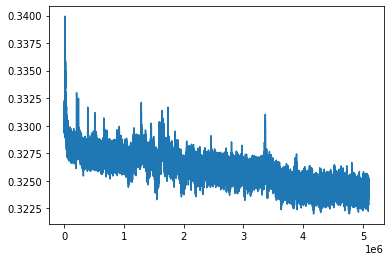

In [55]:
plt.plot(GCAMP[1])

In [30]:


csig = []
ctime = []
peaks = []
for i in range(len(fp)):
    csig.append(sig[i][start[i]:end[i]])
    ctime.append(np.array(time[i][start[i]:end[i]]))
    ds = downsampled_peaks(np.array(csig[i]),fs[i])
    csig.append(ds[0])
    peaks.append(ds[1])
# incage = 100
# outcage = incage+150
# start = np.floor(len(time8)/time8[-1]*incage).astype(int)
# end = np.floor(len(time8)/time8[-1]*outcage).astype(int)
# csig8=sig8[start:end]
# ctime8=np.array(time8[start:end])
# csig8,pk8=downsampled_peaks(np.array(csig8),fs)

[1.63848192,
 1.6633856,
 1.68828928,
 1.71319296,
 1.73809664,
 1.76300032,
 1.787904,
 1.81280768,
 1.83771136,
 1.86261504,
 1.88751872,
 1.9124224,
 1.93732608,
 1.96222976,
 1.98713344,
 2.01203712,
 2.0369408,
 2.06184448,
 2.08674816,
 2.11165184,
 2.13655552,
 2.1614592,
 2.18636288,
 2.21126656,
 2.23617024,
 2.26107392,
 2.2859776,
 2.31088128,
 2.33578496,
 2.36068864,
 2.38559232,
 2.410496,
 2.43539968,
 2.46030336,
 2.48520704,
 2.51011072,
 2.5350144,
 2.55991808,
 2.58482176,
 2.60972544,
 2.63462912,
 2.6595328,
 2.68443648,
 2.70934016,
 2.73424384,
 2.75914752,
 2.7840512,
 2.80895488,
 2.83385856,
 2.85876224,
 2.88366592,
 2.9085696,
 2.93347328,
 2.95837696,
 2.98328064,
 3.00818432,
 3.033088,
 3.05799168,
 3.08289536,
 3.10779904,
 3.13270272,
 3.1576064,
 3.18251008,
 3.20741376,
 3.23231744,
 3.25722112,
 3.2821248,
 3.30702848,
 3.33193216,
 3.35683584,
 3.38173952,
 3.4066432,
 3.43154688,
 3.45645056,
 3.48135424,
 3.50625792,
 3.5311616,
 3.55606528,
 3.58

(0, 410)

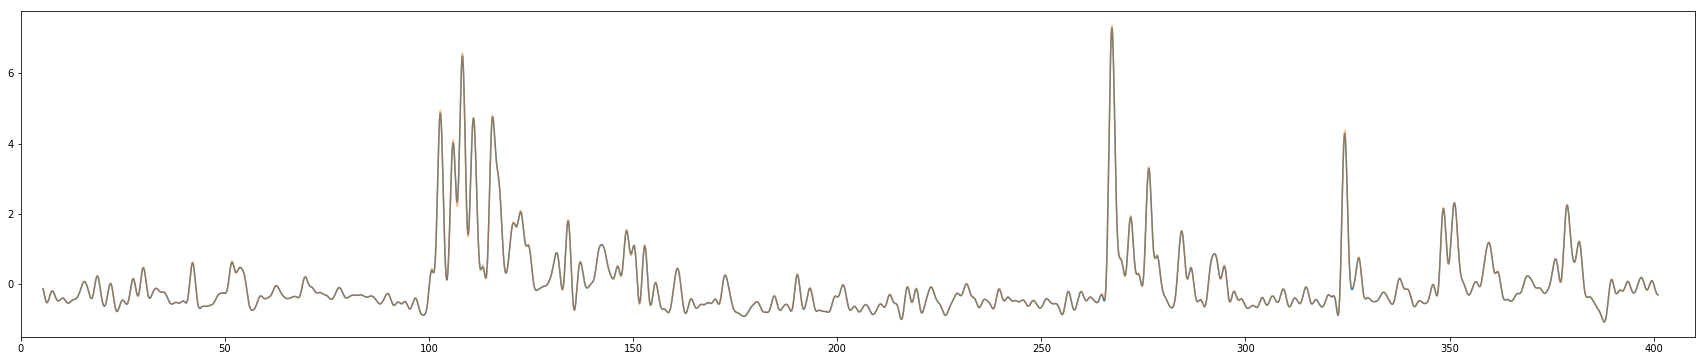

In [213]:
fig,ax = plt.subplots(figsize=(30,6))
test = scipy.signal.detrend(sig1)
test2 = butter_lowpass_filter(test,50,fs,order=3)
test3 = butter_highpass_filter(test2,0.1,fs,order=3)
test4 = scipy.signal.detrend(test3)
test5 = scipy.stats.zscore(test4)
# test5 = scipy.signal.filtfilt(sig1, sig1, sig1)
plt.plot(time1,test5)
plt.plot(time1,scipy.signal.detrend(scipy.stats.zscore(sig1)),alpha=0.5)
error=np.std(sig1)/np.sqrt(len(sig1))
plt.xlim(0,410)

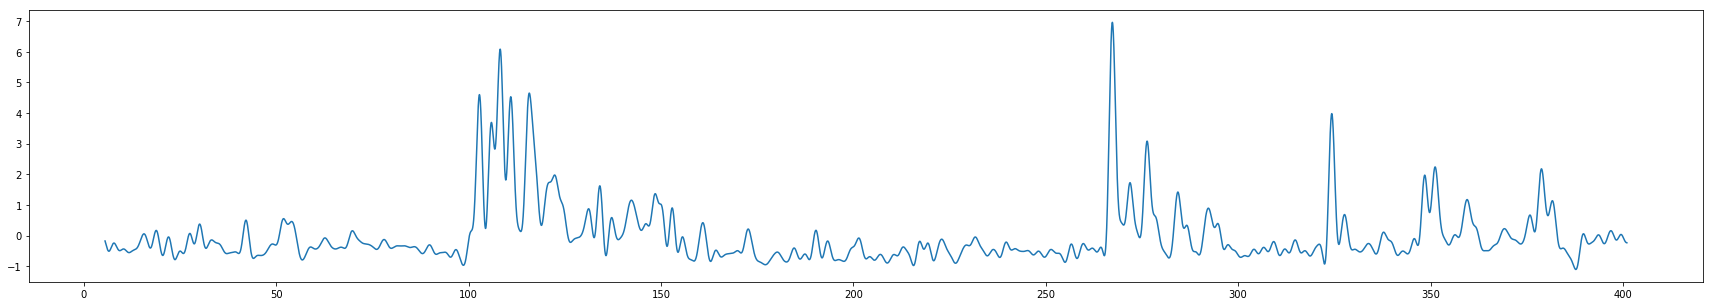

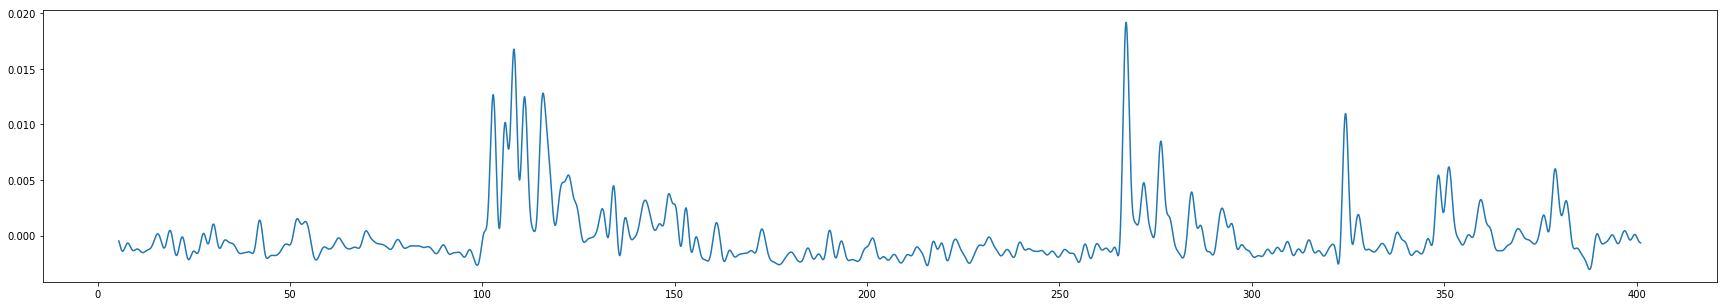

In [216]:
signal = scipy.signal.detrend(sig1)
sig1 = butter_lowpass_filter(signal,40,fs,order=3)
# sig2 = butter_highpass_filter(sig1,0.1,fs,order=3)
sig = scipy.stats.zscore(sig1)
fig,ax=plt.subplots(figsize=(30,5))
plt.plot(time1,sig)
fig,ax=plt.subplots(figsize=(30,5))
plt.plot(time1,(sig1))

### Crop and find peaks:

In [295]:
# balbc male
Cx = pos[0][0]
Cy = pos[0][1]
GCAMP = fp[0][0]
isos = fp[0][1]
fram = fp[0][2]
fs = fp[0][3]
sig1, time1 = downsample_FP(GCAMP, fram, fs, Cx, cam_fr=40)
s1 = filter_signal(sig1, fs)

# C57 female
Cx = pos[1][0]
Cy = pos[1][1]
GCAMP = fp[1][0]
isos = fp[1][1]
fram = fp[1][2]
fs = fp[1][3]
sig2, time2 = downsample_FP(GCAMP, fram, fs, Cx, cam_fr=40)
s2 = filter_signal(sig2, fs)

# C57 male
Cx = pos[2][0]
Cy = pos[2][1]
GCAMP = fp[2][0]
isos = fp[2][1]
fram = fp[2][2]
fs = fp[2][3]
sig3, time3 = downsample_FP(GCAMP, fram, fs, Cx, cam_fr=40)
s3 = filter_signal(sig3, fs)

# SW female
Cx = pos[3][0]
Cy = pos[3][1]
GCAMP = fp[3][0]
isos = fp[3][1]
fram = fp[3][2]
fs = fp[3][3]
sig4, time4 = downsample_FP(GCAMP, fram, fs, Cx, cam_fr=40)
s4 = filter_signal(sig4, fs)

# SW male
Cx = pos[4][0]
Cy = pos[4][1]
GCAMP = fp[4][0]
isos = fp[4][1]
fram = fp[4][2]
fs = fp[4][3]
sig5, time5 = downsample_FP(GCAMP, fram, fs, Cx, cam_fr=40)
s5 = filter_signal(sig5, fs)

# clean
Cx = pos[5][0]
Cy = pos[5][1]
GCAMP = fp[5][0]
isos = fp[5][1]
fram = fp[5][2]
fs = fp[5][3]
sig6, time6 = downsample_FP(GCAMP, fram, fs, Cx, cam_fr=40)
s6 = filter_signal(sig6, fs)

# empty
Cx = pos[6][0]
Cy = pos[6][1]
GCAMP = fp[6][0]
isos = fp[6][1]
fram = fp[6][2]
fs = fp[6][3]
sig7, time7 = downsample_FP(GCAMP, fram, fs, Cx, cam_fr=40)
s7 = filter_signal(sig7, fs)

# home
Cx = pos[7][0]
Cy = pos[7][1]
GCAMP = fp[7][0]
isos = fp[7][1]
fram = fp[7][2]
fs = fp[7][3]
sig8, time8 = downsample_FP(GCAMP, fram, fs, Cx, cam_fr=40)
s8 = filter_signal(sig8, fs)

In [290]:
s5.size

15903

In [311]:
times_in = np.array([100, 95, 92, 90, 90, 98, 90, 1])

In [296]:
# balbc male
# # sig1, time1 = downsample_FP(GCAMP, fram, fs, cam_fr=40)
incage = times_in[0]
outcage = incage+150
start = np.floor(len(time1)/time1[-1]*incage).astype(int)
end = np.floor(len(time1)/time1[-1]*outcage).astype(int)
csig1=s1[start:end]
ctime1=np.array(time1[start:end])
pk1=downsampled_peaks(csig1,fs)

# C57 female
# sig2, time2 = downsample_FP(GCAMP, fram, fs, cam_fr=40)
incage = times_in[1]
outcage = incage+150
start = np.floor(len(time2)/time2[-1]*incage).astype(int)
end = np.floor(len(time2)/time2[-1]*outcage).astype(int)
csig2=s2[start:end]
ctime2=np.array(time2[start:end])
pk2=downsampled_peaks(np.array(csig2),fs)

# C57 male
# sig3, time3 = downsample_FP(GCAMP, fram, fs, cam_fr=40)
incage = times_in[2]
outcage = incage+150
start = np.floor(len(time3)/time3[-1]*incage).astype(int)
end = np.floor(len(time3)/time3[-1]*outcage).astype(int)
csig3=s3[start:end]
ctime3=np.array(time3[start:end])
pk3=downsampled_peaks(np.array(csig3),fs)

# SW female
# sig4, time4 = downsample_FP(GCAMP, fram, fs, cam_fr=40)
incage = times_in[3]
outcage = incage+150
start = np.floor(len(time4)/time4[-1]*incage).astype(int)
end = np.floor(len(time4)/time4[-1]*outcage).astype(int)
csig4=s4[start:end]
ctime4=np.array(time4[start:end])
pk4=downsampled_peaks(np.array(csig4),fs)

# SW male
# sig5, time5 = downsample_FP(GCAMP, fram, fs, cam_fr=40)
incage = times_in[4]
outcage = incage+150
start = np.floor(len(time5)/time5[-1]*incage).astype(int)
end = np.floor(len(time5)/time5[-1]*outcage).astype(int)
csig5=s5[start:end]
ctime5=np.array(time5[start:end])
pk5=downsampled_peaks(np.array(csig5),fs)

# clean
# sig6, time6 = downsample_FP(GCAMP, fram, fs, cam_fr=40)
incage = times_in[5]
outcage = incage+150
start = np.floor(len(time6)/time6[-1]*incage).astype(int)
end = np.floor(len(time6)/time6[-1]*outcage).astype(int)
csig6=s6[start:end]
ctime6=np.array(time6[start:end])
pk6=downsampled_peaks(np.array(csig6),fs)

# empty
# sig7, time7 = downsample_FP(GCAMP, fram, fs, cam_fr=40)
incage = times_in[6]
outcage = incage+150
start = np.floor(len(time7)/time7[-1]*incage).astype(int)
end = np.floor(len(time7)/time7[-1]*outcage).astype(int)
csig7=s7[start:end]
ctime7=np.array(time7[start:end])
pk7=downsampled_peaks(np.array(csig7),fs)

# home
# sig8, time8 = downsample_FP(GCAMP, fram, fs, cam_fr=40)
incage = times_in[7]
outcage = incage+150
start = np.floor(len(time8)/time8[-1]*incage).astype(int)
end = np.floor(len(time8)/time8[-1]*outcage).astype(int)
csig8=s8[start:end]
ctime8=np.array(time8[start:end])
pk8=downsampled_peaks(np.array(csig8),fs)

In [297]:
csig1

array([ 0.69557086,  0.69935527,  0.70344811, ..., -0.62334471,
       -0.62668705, -0.62967323])

### Plot raw traces:

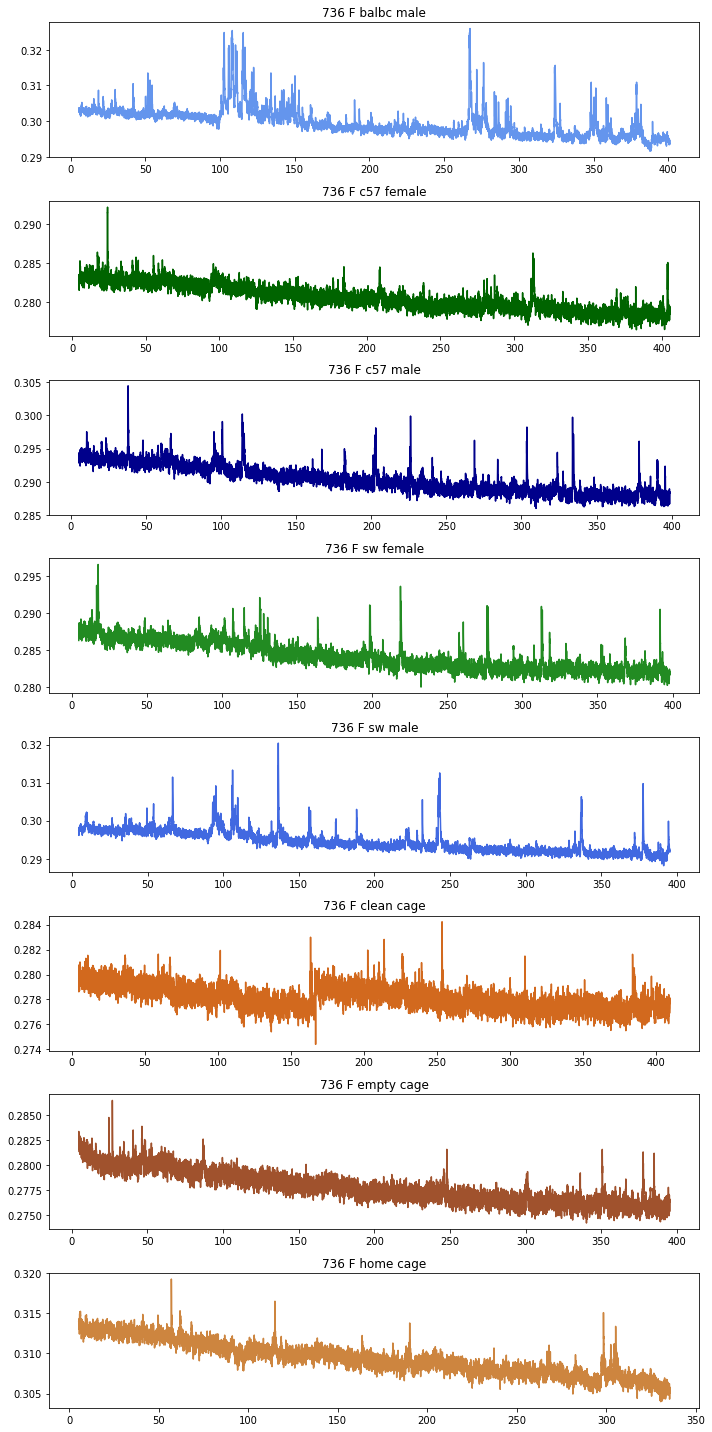

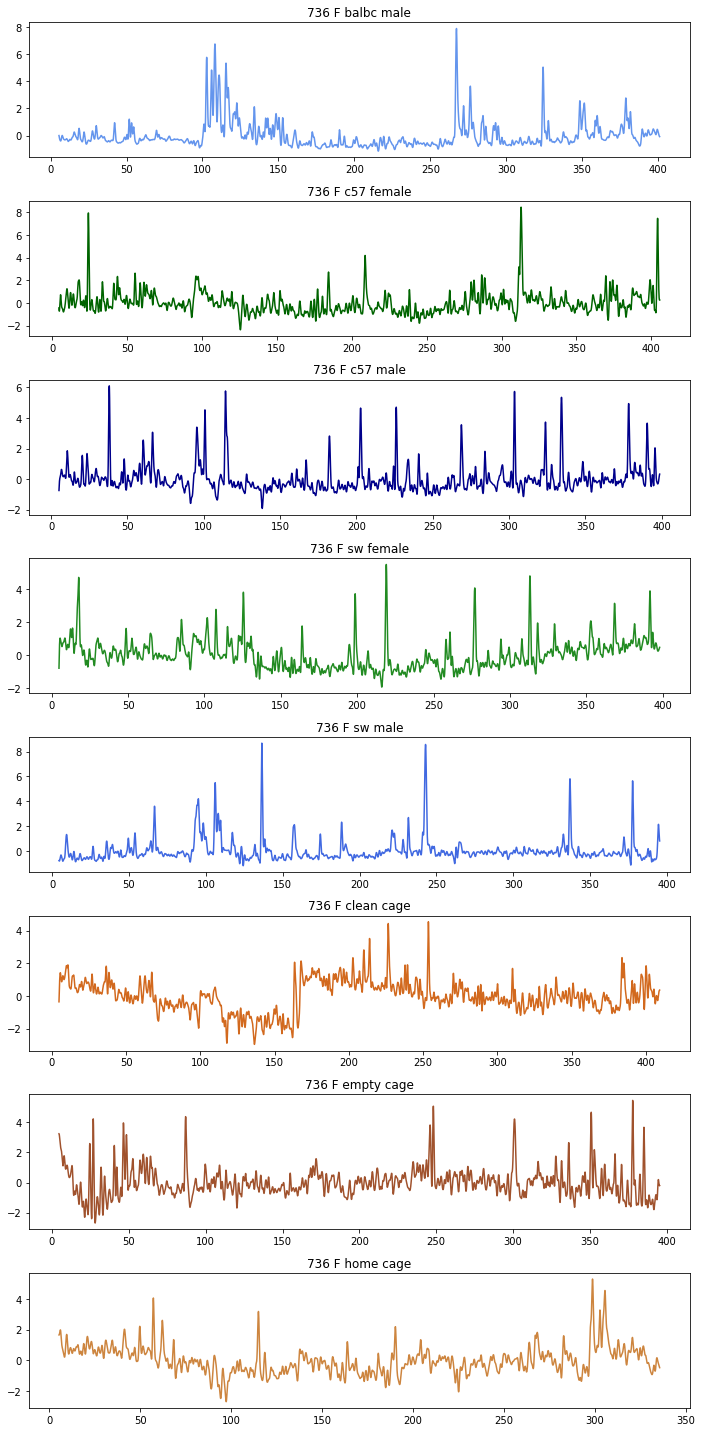

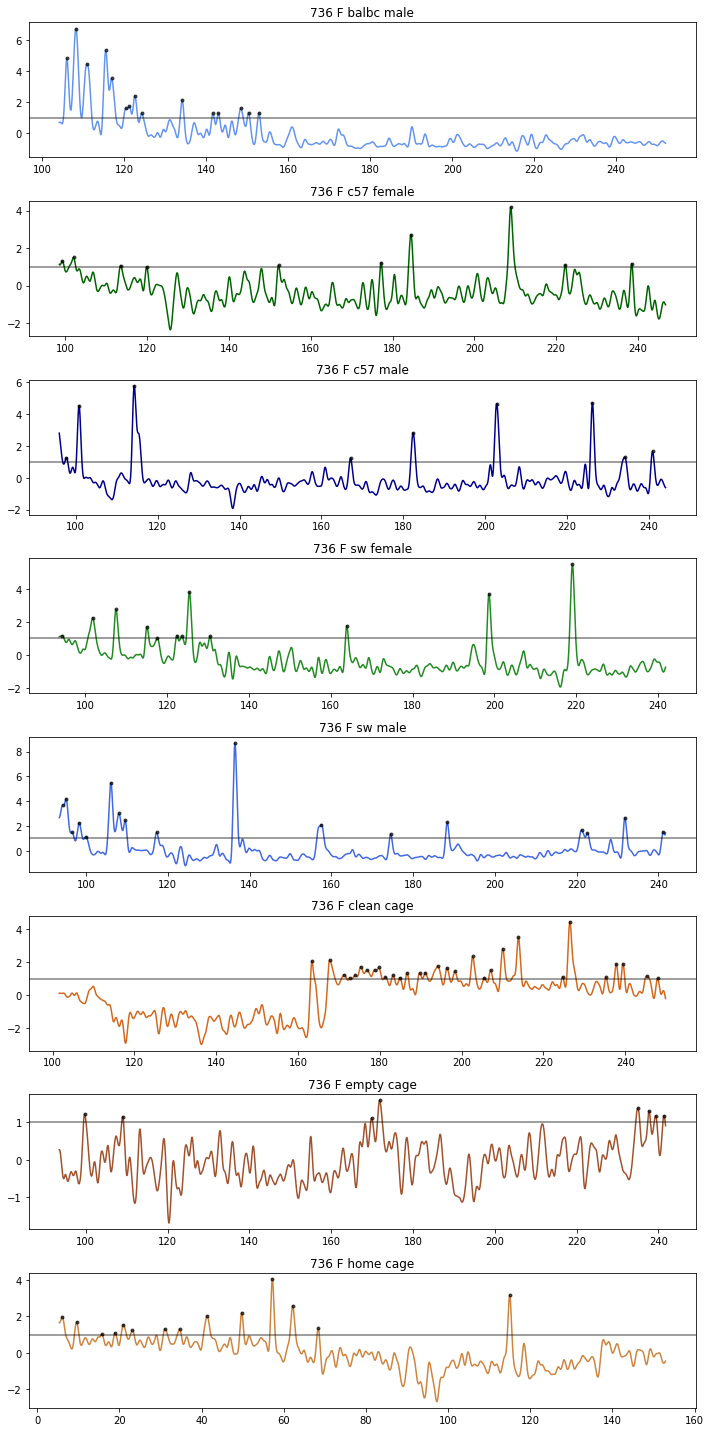

In [312]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8)=plt.subplots(8,figsize=(10,20))
ax1.plot(time1, sig1, label='balbc male', c='cornflowerblue')
ax2.plot(time2, sig2, label='C57 female', c='darkgreen')
ax3.plot(time3, sig3, label='C57 male', c='darkblue')
ax4.plot(time4, sig4, label='SW female', c='forestgreen')
ax5.plot(time5, sig5, label='SW male', c='royalblue')
ax6.plot(time6, sig6, label='clean', c='chocolate')
ax7.plot(time7, sig7, label='empty', c='sienna')
ax8.plot(time8, sig8, label='home', c='peru')
ax1.set_title('741 M balbc male')
ax2.set_title('741 M c57 female')
ax3.set_title('741 M c57 male')
ax4.set_title('741 M sw female')
ax5.set_title('741 M sw male')
ax6.set_title('741 M clean cage')
ax7.set_title('741 M empty cage')
ax8.set_title('741 M home cage')
plt.tight_layout()
plt.savefig('/Users/dakotab/Desktop/PMVdatExperiments/CageContext/741M_rawtraces.png',dpi=300)

fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8)=plt.subplots(8,figsize=(10,20))
ax1.plot(time1, s1, label='balbc male', c='cornflowerblue')
ax2.plot(time2, s2, label='C57 female', c='darkgreen')
ax3.plot(time3, s3, label='C57 male', c='darkblue')
ax4.plot(time4, s4, label='SW female', c='forestgreen')
ax5.plot(time5, s5, label='SW male', c='royalblue')
ax6.plot(time6, s6, label='clean', c='chocolate')
ax7.plot(time7, s7, label='empty', c='sienna')
ax8.plot(time8, s8, label='home', c='peru')
ax1.set_title('741 M balbc male')
ax2.set_title('741 M c57 female')
ax3.set_title('741 M c57 male')
ax4.set_title('741 M sw female')
ax5.set_title('741 M sw male')
ax6.set_title('741 M clean cage')
ax7.set_title('741 M empty cage')
ax8.set_title('741 M home cage')
plt.tight_layout()
plt.savefig('/Users/dakotab/Desktop/PMVdatExperiments/CageContext/741M_downsampled.png',dpi=300)

fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8)=plt.subplots(8,figsize=(10,20))
ax1.plot(ctime1, csig1, label='BalbC male', c='cornflowerblue')
ax1.plot(ctime1[pk1], csig1[pk1], '.',alpha=0.65, c='k')
ax1.axhline(1, c='k', alpha=0.5)

ax2.plot(ctime2, csig2, label='C57 female', c='darkgreen')
ax2.plot(ctime2[pk2], csig2[pk2], '.',alpha=0.65, c='k')
ax2.axhline(1, c='k', alpha=0.5)

ax3.plot(ctime3, csig3, label='C57 male', c='darkblue')
ax3.plot(ctime3[pk3], csig3[pk3], '.',alpha=0.65, c='k')
ax3.axhline(1, c='k', alpha=0.5)

ax4.plot(ctime4, csig4, label='SW female', c='forestgreen')
ax4.plot(ctime4[pk4], csig4[pk4], '.',alpha=0.65, c='k')
ax4.axhline(1, c='k', alpha=0.5)

ax5.plot(ctime5, csig5, label='SW male', c='royalblue')
ax5.plot(ctime5[pk5], csig5[pk5], '.',alpha=0.65, c='k')
ax5.axhline(1, c='k', alpha=0.5)

ax6.plot(ctime6, csig6, label='clean', c='chocolate')
ax6.plot(ctime6[pk6], csig6[pk6], '.',alpha=0.65, c='k')
ax6.axhline(1, c='k', alpha=0.5)

ax7.plot(ctime7, csig7, label='empty', c='sienna')
ax7.plot(ctime7[pk7], csig7[pk7], '.',alpha=0.65, c='k')
ax7.axhline(1, c='k', alpha=0.5)

ax8.plot(ctime8, csig8, label='home', c='peru')
ax8.plot(ctime8[pk8],csig8[pk8],'.',alpha=0.65, c='k')
ax8.axhline(1, c='k', alpha=0.5)
ax1.set_title('741 M balbc male')
ax2.set_title('741 M c57 female')
ax3.set_title('741 M c57 male')
ax4.set_title('741 M sw female')
ax5.set_title('741 M sw male')
ax6.set_title('741 M clean cage')
ax7.set_title('741 M empty cage')
ax8.set_title('741 M home cage')
plt.tight_layout()
plt.savefig('/Users/dakotab/Desktop/PMVdatExperiments/CageContext/741M_peaksincage.png',dpi=300)

Text(0.5,1,'736F Home Cage')

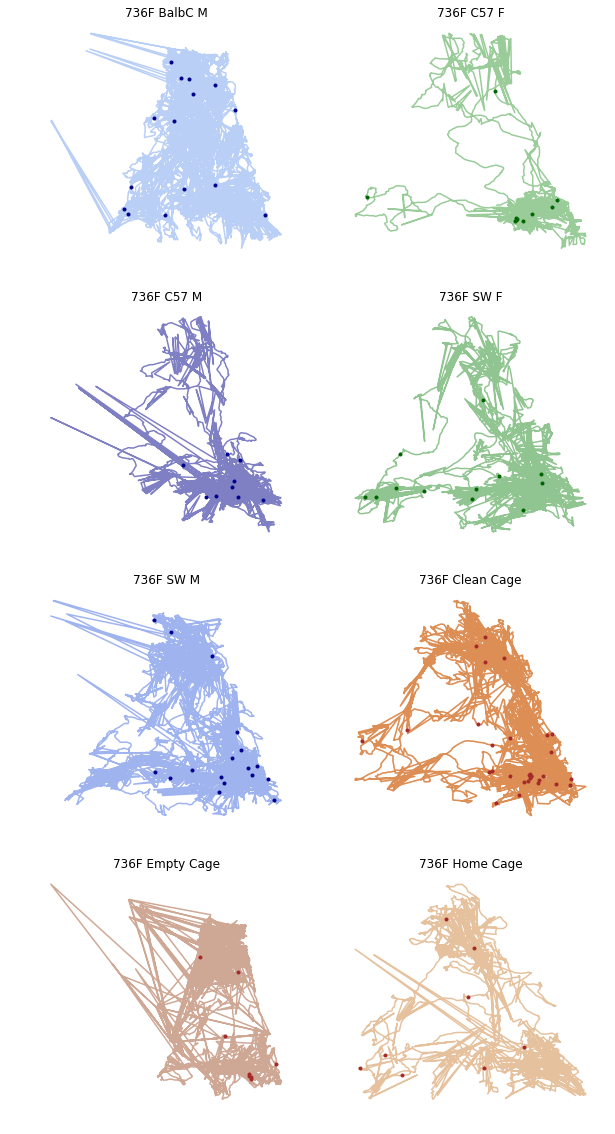

In [320]:
fig, axes = plt.subplots(4,2,figsize=(10,20))

# balbc male
# sig2, time2 = downsample_FP(GCAMP, fram, fs, cam_fr=40)
incage = (times_in[0])*40
outcage = (incage+150)*40
Cx = pos[0][0][incage:outcage]
Cy = pos[0][1][incage:outcage]
axes[0,0].plot(Cx,Cy,c='cornflowerblue',alpha=0.45)
axes[0,0].plot(Cx[pk1],Cy[pk1],'.',c='darkblue')
axes[0,0].set_title('736F BalbC M')
axes[0,0].axis('off')

# C57 female
# sig2, time2 = downsample_FP(GCAMP, fram, fs, cam_fr=40)
incage = (times_in[1])*40
outcage = (incage+150)*40
Cx = pos[1][0][incage:outcage]
Cy = pos[1][1][incage:outcage]
axes[0,1].plot(Cx,Cy,c='green',alpha=0.4)
axes[0,1].plot(Cx[pk2],Cy[pk2],'.',c='darkgreen')
axes[0,1].set_title('736F C57 F')
axes[0,1].axis('off')

# C57 male
# sig3, time3 = downsample_FP(GCAMP, fram, fs, cam_fr=40)
incage = (times_in[2])*40
outcage = (incage+150)*40
Cx = pos[2][0][incage:outcage]
Cy = pos[2][1][incage:outcage]
axes[1,0].plot(Cx,Cy,c='darkblue',alpha=0.5)
axes[1,0].plot(Cx[pk3],Cy[pk3],'.',c='darkblue')
axes[1,0].axis('off')
axes[1,0].set_title('736F C57 M')

# SW female
# sig4, time4 = downsample_FP(GCAMP, fram, fs, cam_fr=40)
incage = (times_in[3])*40
outcage = (incage+150)*40
Cx = pos[3][0][incage:outcage]
Cy = pos[3][1][incage:outcage]
axes[1,1].plot(Cx,Cy,c='forestgreen',alpha=0.5)
axes[1,1].plot(Cx[pk4],Cy[pk4],'.',c='darkgreen')
axes[1,1].axis('off')
axes[1,1].set_title('736F SW F')

# SW male
# sig5, time5 = downsample_FP(GCAMP, fram, fs, cam_fr=40)
incage = (times_in[4])*40
outcage = (incage+150)*40
Cx = pos[4][0][incage:outcage]
Cy = pos[4][1][incage:outcage]
axes[2,0].plot(Cx,Cy,c='royalblue',alpha=0.5)
axes[2,0].plot(Cx[pk5],Cy[pk5],'.',c='darkblue')
axes[2,0].axis('off')
axes[2,0].set_title('736F SW M')

# clean
# 741: home
# sig6, time6 = downsample_FP(GCAMP, fram, fs, cam_fr=40)
incage = (times_in[5])*40
outcage = (incage+150)*40
Cx = pos[5][0][incage:outcage]
Cy = pos[5][1][incage:outcage]
axes[2,1].plot(Cx,Cy,c='Chocolate',alpha=0.5)
axes[2,1].plot(Cx,Cy,c='chocolate',alpha=0.5)
axes[2,1].plot(Cx[pk6],Cy[pk6],'.',c='brown')
axes[2,1].axis('off')
axes[2,1].set_title('736F Clean Cage')

# empty
# sig7, time7 = downsample_FP(GCAMP, fram, fs, cam_fr=40)
incage = (times_in[6])*40
outcage = (incage+150)*40
Cx = pos[6][0][incage:outcage]
Cy = pos[6][1][incage:outcage]
axes[3,0].plot(Cx,Cy,c='sienna',alpha=0.5)
axes[3,0].plot(Cx[pk7],Cy[pk7],'.',c='brown')
axes[3,0].axis('off')
axes[3,0].set_title('736F Empty Cage')

# home
# sig8, time8 = downsample_FP(GCAMP, fram, fs, cam_fr=40)
incage = (times_in[7])*40
outcage = (incage+150)*40
Cx = pos[7][0][incage:outcage]
Cy = pos[7][1][incage:outcage]
axes[3,1].plot(Cx,Cy,c='peru',alpha=0.5)
axes[3,1].plot(Cx[pk7],Cy[pk7],'.',c= 'brown')
axes[3,1].axis('off')
axes[3,1].set_title('736F Home Cage')

# plt.savefig('/Users/dakotab/Desktop/PMVdatExperiments/CageContext/736F_peak_locations.png', dpi=300)

In [302]:
Cx[pk1]

array([892.21096611, 918.51778239, 743.08800441, 736.96652058,
       604.83327091, 679.2629509 , 665.70738393, 720.5614999 ,
       781.22240621, 775.74766016, 903.62968996, 920.7009564 ,
       907.29576695, 846.87654114, 619.45108968])

In [23]:
# fp_dat = sorted(glob.glob('/Volumes/falkner/Dakota/PMV_AM/datM741_pairwise_BalbC/pairwise*'))
# fp = [load_fp(f) for f in fp_dat]

fp = load_fp('/Volumes/falkner/Dakota/PMV_AM/datM745_pairwise_BalbC_homecage1H/')

read from t=0s to t=457.95s


Text(0.5,1,'a brief interlude: what the fuck happened to my signal')

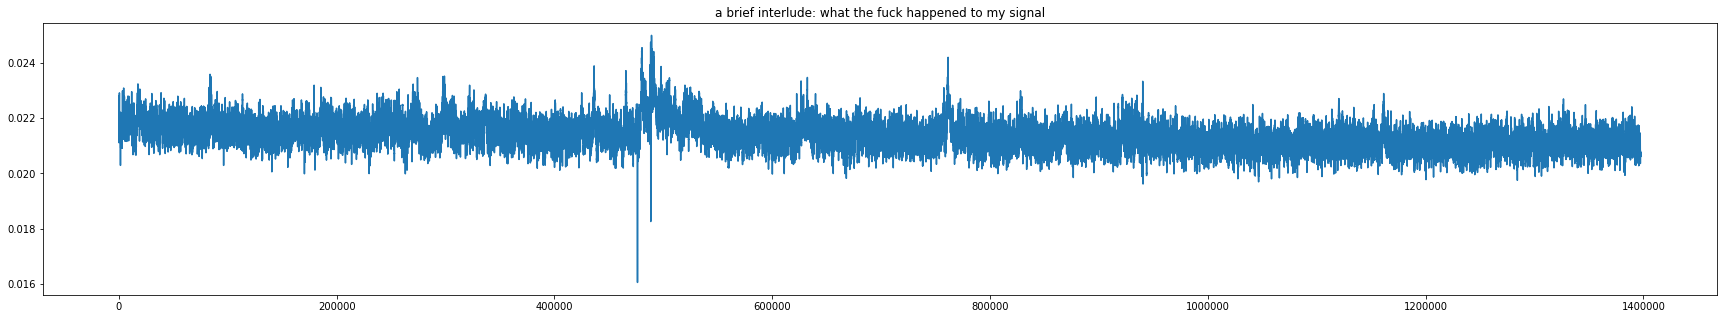

In [27]:
fig,ax=plt.subplots(figsize=(30,5))
plt.plot(fp[0])
plt.title('a brief interlude: what the fuck happened to my signal')

read from t=0s to t=463.57s


Text(0.5,1,'interlude over: next time make sure your PATCH CORD IS ATTACHED CORRECTLY')

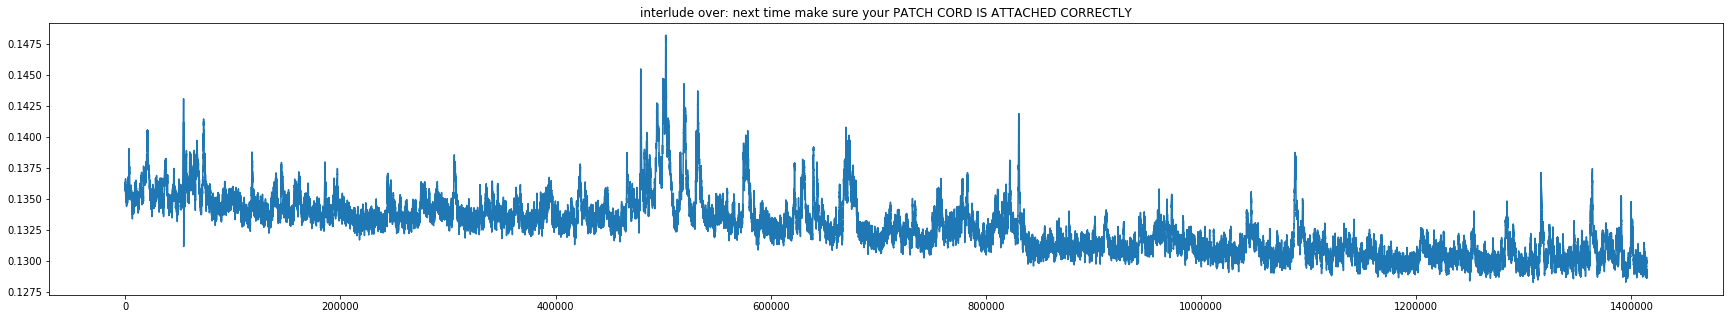

In [30]:
fp = load_fp('/Volumes/falkner/Dakota/PMV_AM/datM745_pairwise_BalbC/pairwise_BalbC_homecage1/')
fig,ax=plt.subplots(figsize=(30,5))
plt.plot(fp[0])
plt.title('interlude over: next time make sure your PATCH CORD IS ATTACHED CORRECTLY')

In [ ]:
# load csv data & compute centroids
csv_file_path = '/Volumes/falkner/Dakota/PMV_AM/191218_datM741_cageday/191218_datM741_homecage_b-12182019132759-0000DeepCut_resnet50_191219_PMVcagedayDec19shuffle1_1030000.csv'
Cx, Cy = load_dlc(csv_file_path)
TCDistance, LCDistance, RCDistance = calculate_cage_distance(csv_file_path)

# load FP data & extract gcamp, fram, isos, etc
# downsample data based on Cx, Cy
fp_file_path = '/Volumes/falkner/Dakota/PMV_AM/191218_datM741_cageday/191218_datM741_homecage/'
GCAMP, ISOS, fram, fs = load_fp(fp_file_path)

In [ ]:
# downsample, detrend & calculate peaks
signal_ds, time_ds = downsample_FP(GCAMP, fram, fs, cam_fr=40)
sig,peaks = downsampled_peaks(np.array(signal_ds), fs)
zscore = scipy.stats.zscore(sig)

fig,(ax1,ax2,ax3,ax4)=plt.subplots(4, figsize=(30,5))
ax1.plot(time_ds, zscore)
ax2.plot(RCDistance, c='darkgreen')
ax3.plot(LCDistance, c='purple')
ax4.plot(TCDistance, c='darkblue')

In [ ]:
time_x = np.linspace(1, npts, npts) / fs
incage = 112
start_cage = np.floor(time_x.size/time_x[-1]*incage).astype(int)
start_cage
frame_in = incage * 40 #fps
Cx = Cx[frame_in:-1]
Cy = Cy[frame_in:-1]

In [ ]:
tx = scipy.stats.binned_statistic(TCDistance, zscore, statistic='mean', bins=100)[0]
ty = scipy.stats.binned_statistic(TCDistance, zscore, statistic='mean', bins=100)[1]
tbin_centers = [np.mean([ty[i], ty[i+1]]) for i in range(len(ty)-1)]

rx = scipy.stats.binned_statistic(RCDistance, zscore, statistic='mean', bins=100)[0]
ry = scipy.stats.binned_statistic(RCDistance, zscore, statistic='mean', bins=100)[1]
rbin_centers = [np.mean([ry[i], ry[i+1]]) for i in range(len(ry)-1)]

lx = scipy.stats.binned_statistic(LCDistance, zscore, statistic='mean', bins=100)[0]
ly = scipy.stats.binned_statistic(LCDistance, zscore, statistic='mean', bins=100)[1]
lbin_centers = [np.mean([ly[i], ly[i+1]]) for i in range(len(ly)-1)]
lbin_centers = np.array(lbin_centers)
# lbin_centers = lbin_centers - 400

fig,ax=plt.subplots(figsize=(15,5))
plt.plot(tbin_centers, tx, c='darkblue', label='top corner distance')
plt.plot(rbin_centers, rx, c='darkgreen', label='right corner distance')
plt.plot(lbin_centers, lx, c='purple', label='left corner distance')
# plt.xlim(0,1100)
plt.ylabel('z score')
plt.xlabel('distance (pixels)')
plt.title('SWM Cage')
plt.legend(loc=1)

In [ ]:
np.where(np.isnan(rx)==True)

In [ ]:
def downsample_FP(signal, fram, fs, cam_fr=40, Cx=Cx):
    """
    Inputs:
    -------
    signal: GCAMP (or isosbestic) array of signal values from the TDT system
    fram: array of camera onset times accoording to TDT
    fs: sampling frequency of data
    cam_fr: camera frame rate. in our case values are the same for all cage day trials, but they may not always be!
    Cx: required for downsampling based on positional tracking using dlc
    
    Returns:
    --------
    signal_ds: downsampled signal based on dx
    """
    import math
    sr_diff = fs/cam_fr
    rec_onset = fram[0]
    rec_offset = fram[-1]
    
    ## FIRST: restrict signal to times when camera is on
    # Turn the GCAMP frames into seconds 
    signal_times = np.arange(0, (len(signal)/fs), (1/fs))
    # Calculate the index within the GCAMP stream that the camera turns on 
    cam_on_idx = (np.where(signal_times==(find_nearest(signal_times,rec_onset))))
    # Calculate the time in sec within the GCAMP stream that the camera turns on
    cam_on_sec = signal_times[cam_on_idx][0]
    # Calculate the index within the GCAMP stream that the camera turns off 
    cam_off_idx = (np.where(signal_times==(find_nearest(signal_times, rec_offset))))
    # Calculate the time in sec within the GCAMP stream that the camera turns off
    cam_off_sec = signal_times[cam_off_idx][0] 
    # crop GCAMP signal from camera on to camera off
    signal_cropped = signal[cam_on_idx[0][0]:cam_off_idx[0][0]]
    
    # Create time array based on number of samples and sample frequency
    # crop time signal from camera on to camera off
    npts = len(signal)
    time_x = np.linspace(1, npts, npts) / fs
    # do the same for the time vector
    signal_cropped_time = len(signal_cropped)/fs
    time_cropped = time_x[cam_on_idx[0][0]:cam_off_idx[0][0]]
    # Downsample the cropped GCAMP recording to align with the camera frames so can match up with 
    # the Cx and Cy vectors
    signal_ds = []
    for idx, frame in enumerate(Cx):
        signal_ds.append(signal_cropped[int(np.round((idx*sr_diff)))])
    time_ds = []
    for idx, frame in enumerate(Cx):
        time_ds.append(time_cropped[int(np.round((idx*sr_diff)))])
    return signal_ds, time_ds

In [ ]:
load_fp('/Volumes/falkner/Dakota/PMV_AM/191219_datM746_cageday/')

In [ ]:
import math
sr_diff = fs/cam_fr
rec_onset = fram[0]
rec_offset = fram[-1]

# ## FIRST: restrict signal to times when camera is on
# # Turn the GCAMP frames into seconds 
# signal_times = np.arange(0, (len(signal)/fs), (1/fs))
# # Calculate the index within the GCAMP stream that the camera turns on 
# cam_on_idx = (np.where(signal_times==(find_nearest(signal_times,rec_onset))))
# # Calculate the time in sec within the GCAMP stream that the camera turns on
# cam_on_sec = signal_times[cam_on_idx][0]
# # Calculate the index within the GCAMP stream that the camera turns off 
# cam_off_idx = (np.where(signal_times==(find_nearest(signal_times, rec_offset))))
# # Calculate the time in sec within the GCAMP stream that the camera turns off
# cam_off_sec = signal_times[cam_off_idx][0] 
# # crop GCAMP signal from camera on to camera off
# signal_cropped = signal[cam_on_idx[0][0]:cam_off_idx[0][0]]

# # Create time array based on number of samples and sample frequency
# # crop time signal from camera on to camera off
# npts = len(signal)
# time_x = np.linspace(1, npts, npts) / fs
# # do the same for the time vector
# signal_cropped_time = len(signal_cropped)/fs
# time_cropped = time_x[cam_on_idx[0][0]:cam_off_idx[0][0]]
# # Downsample the cropped GCAMP recording to align with the camera frames so can match up with 
# # the Cx and Cy vectors
# signal_ds = []
# for idx, frame in enumerate(Cx):
#     signal_ds.append(signal_cropped[int(np.round((idx*sr_diff)))])
# time_ds = []
# for idx, frame in enumerate(Cx):
#     time_ds.append(time_cropped[int(np.round((idx*sr_diff)))])